In [1]:
import numpy as np
import pickle as pkl
import torch
from scipy.spatial.distance import cosine, euclidean
from scipy import stats
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
#import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
import networkx as nx

In [5]:
import operator
import random
import os

In [6]:
%matplotlib inline

In [7]:
import bz2
import _pickle as cPickle

# Load any compressed pickle file
def decompress_pickle(file):
    assert file.endswith("pbz2")
    data = bz2.BZ2File(file, "rb")
    data = cPickle.load(data,encoding="latin1")
    return data

In [8]:
#data

In [9]:
version_no = "2"

In [10]:
data_dir = "./../../data/pubmed_heuristic/"
data_dir_hin = "./../../data_hin/PubMed_orig/"
fname = data_dir + "pubmed_heuristic_data_dict_v"+version_no+"_p2.pkl.pbz2"

In [11]:
out_dir = "./../../out_clust/pubmed_heuristic/version_"+version_no+"/cc/"

In [12]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [13]:
is_abs_A = False

In [14]:
is_fac_pp = False

In [15]:
num_matrices = 10

In [16]:
fname

'./../../data/pubmed_heuristic/pubmed_heuristic_data_dict_v2_p2.pkl.pbz2'

In [17]:
#data_dict = pkl.load(open(fname,"rb"))
data_dict = decompress_pickle(fname)

In [18]:
list_x_id_new = list(data_dict["matrices"].keys())
list_e_id_new = list(data_dict["metadata"]["dict_e_size"].keys())

In [19]:
dict_map_xid = {'X11': "X0",
 'X12': "X1",
 'X22': "X2",
 'X31': "X3",
 'X32': "X4",
 'X33': "X5",
 'X34': "X6",
 'X41': "X7",
 'X42': "X8",
 'X44': "X9"}

In [20]:
dict_map_eid = {
    "e1":"e0",
    "e2":"e1",
    "e3":"e2",
    "e4":"e3"
}

In [21]:
list_x_id = []
for x_id in list_x_id_new:
    list_x_id.append(dict_map_xid[x_id])
#
list_e_id = []
for e_id in list_e_id_new:
    list_e_id.append(dict_map_eid[e_id])
    

In [22]:
print("Loading the matrices: ")
dict_id_X = {}
X_data_bef_pp = {}
for x_id in data_dict["matrices"].keys():
    new_x_id = dict_map_xid[x_id]
    dict_id_X[new_x_id] = data_dict["matrices"][x_id]
    X_data_bef_pp[new_x_id] = dict_id_X[new_x_id]
    print("x_id: ",new_x_id," X.shape: ",dict_id_X[new_x_id].shape)
print("#")

Loading the matrices: 
x_id:  X4  X.shape:  (5660, 4405)
x_id:  X5  X.shape:  (5660, 5660)
x_id:  X3  X.shape:  (5660, 2634)
x_id:  X7  X.shape:  (608, 2634)
x_id:  X6  X.shape:  (5660, 608)
x_id:  X8  X.shape:  (608, 4405)
x_id:  X9  X.shape:  (608, 608)
x_id:  X0  X.shape:  (2634, 2634)
x_id:  X1  X.shape:  (2634, 4405)
x_id:  X2  X.shape:  (4405, 4405)
#


In [23]:
#
print("#")
print("Before pp:")
print("#")
for temp_id in list_x_id:
    print("X_"+str(temp_id),": min: ",dict_id_X[temp_id].min()," max: ",dict_id_X[temp_id].max()," mean: ",np.round(dict_id_X[temp_id].mean(),4)," sd: ",np.round(dict_id_X[temp_id].std(),4))
print("#")

#
Before pp:
#
X_X4 : min:  0.0  max:  1161.0  mean:  0.0021  sd:  0.628
X_X5 : min:  0.0  max:  106.0  mean:  0.0004  sd:  0.0683
X_X3 : min:  0.0  max:  1146.0  mean:  0.0013  sd:  0.3509
X_X7 : min:  0.0  max:  133.0  mean:  0.0009  sd:  0.1251
X_X6 : min:  0.0  max:  97.0  mean:  0.0007  sd:  0.0923
X_X8 : min:  0.0  max:  221.0  mean:  0.0015  sd:  0.2319
X_X9 : min:  0.0  max:  16.0  mean:  0.0004  sd:  0.0386
X_X0 : min:  0.0  max:  115.0  mean:  0.0012  sd:  0.1377
X_X1 : min:  0.0  max:  2041.0  mean:  0.0031  sd:  0.9071
X_X2 : min:  0.0  max:  910.0  mean:  0.0014  sd:  0.5287
#


In [24]:
def get_size_fac_pp(X_cg):
    #print("get_size_fac_pp - X.shape: ",X_cg.shape)
    #
    epsilon1 = 1
    epsilon2 = 0
    X_cg = X_cg + epsilon1
    #print("get_size_fac_pp - X.shape: ",X_cg.shape)
    X_cg_sum = np.sum(X_cg,axis=1)
    X_cg_size_fac = X_cg_sum / (np.median(X_cg_sum)+epsilon2)
    #print("get_size_fac_pp - X_cg_size_fac.shape: ",X_cg_size_fac.shape)
    #Eqn (4)
    X_cg_size_fac_diag = np.diag(1.0 / X_cg_size_fac)
    X_cg_size_fac_diag_mm_x = np.dot(X_cg_size_fac_diag,X_cg)
    X_cg_size_fac_diag_mm_x_log = np.log(X_cg_size_fac_diag_mm_x + 1)
    #print("get_size_fac_pp - X_cg_size_fac_diag_mm_x_log.shape: ",X_cg_size_fac_diag_mm_x_log.shape)
    pp_scaler = StandardScaler()
    X_cg_size_fac_diag_mm_x_log_std = pp_scaler.fit_transform(X_cg_size_fac_diag_mm_x_log)
    #
    #X_cg_size_fac = X_cg_size_fac - 1
    #
    return X_cg_size_fac, X_cg_size_fac_diag_mm_x_log_std
#

In [25]:
print("Preprocessing the matrices: ")
dict_id_X_pp = {}
X_data_size_fac = {}
for temp_id in list_x_id:
    if is_fac_pp:
        _, dict_id_X_pp[temp_id] = get_size_fac_pp(dict_id_X[temp_id])
    else:
        epsilon = 1e-10
        X_temp = dict_id_X[temp_id]
        # X_temp = pd.DataFrame(X_temp).fillna(0).to_numpy()
        # X_temp = np.log(X_temp + 1.0) + epsilon
        # X_temp = np.nan_to_num(X_temp)
        scaler1 = StandardScaler()
        dict_id_X_pp[temp_id] = scaler1.fit_transform(X_temp) #dict_id_X[temp_id])
    print("temp_id: ",temp_id," X.shape: ",dict_id_X_pp[temp_id].shape)        
print("#")

Preprocessing the matrices: 
temp_id:  X4  X.shape:  (5660, 4405)
temp_id:  X5  X.shape:  (5660, 5660)
temp_id:  X3  X.shape:  (5660, 2634)
temp_id:  X7  X.shape:  (608, 2634)
temp_id:  X6  X.shape:  (5660, 608)
temp_id:  X8  X.shape:  (608, 4405)
temp_id:  X9  X.shape:  (608, 608)
temp_id:  X0  X.shape:  (2634, 2634)
temp_id:  X1  X.shape:  (2634, 4405)
temp_id:  X2  X.shape:  (4405, 4405)
#


In [26]:
print("#")
print("After pp:")
print("#")
for temp_id in list_x_id:
    print("X_"+str(temp_id),": min: ",np.round(dict_id_X_pp[temp_id].min(),4)," max: ",np.round(dict_id_X_pp[temp_id].max(),4)," mean: ",np.round(dict_id_X_pp[temp_id].mean(),4)," sd: ",np.round(dict_id_X_pp[temp_id].std(),4))
print("#")

#
After pp:
#
X_X4 : min:  -0.149  max:  75.2263  mean:  -0.0  sd:  0.686
X_X5 : min:  -0.1141  max:  75.2263  mean:  0.0  sd:  0.6912
X_X3 : min:  -0.0933  max:  75.2263  mean:  0.0  sd:  0.7288
X_X7 : min:  -0.1183  max:  24.6374  mean:  0.0  sd:  0.3561
X_X6 : min:  -0.0603  max:  75.2263  mean:  0.0  sd:  0.6847
X_X8 : min:  -0.2594  max:  24.6374  mean:  0.0  sd:  0.2929
X_X9 : min:  -0.1236  max:  24.6374  mean:  0.0  sd:  0.3295
X_X0 : min:  -0.1389  max:  51.3128  mean:  -0.0  sd:  0.7611
X_X1 : min:  -0.1642  max:  51.3128  mean:  0.0  sd:  0.6066
X_X2 : min:  -0.0959  max:  66.3626  mean:  -0.0  sd:  0.78
#


In [27]:
X_meta_new = data_dict["metadata"]["x_meta"] 
X_meta = {}
for temp_x_id in X_meta_new.keys():
    x_id = dict_map_xid[temp_x_id]
    row_eid = dict_map_eid[X_meta_new[temp_x_id][0]]
    col_eid = dict_map_eid[X_meta_new[temp_x_id][1]]
    X_meta[x_id] = [row_eid, col_eid]

In [28]:
X_meta

{'X0': ['e0', 'e0'],
 'X1': ['e0', 'e1'],
 'X2': ['e1', 'e1'],
 'X3': ['e2', 'e0'],
 'X4': ['e2', 'e1'],
 'X5': ['e2', 'e2'],
 'X6': ['e2', 'e3'],
 'X7': ['e3', 'e0'],
 'X8': ['e3', 'e1'],
 'X9': ['e3', 'e3']}

In [29]:
# X_meta = {
#     "X0":["e0","e0"],
#     "X1":["e0","e1"],
#     "X2":["e1","e1"],
#     "X3":["e2","e0"],
#     "X4":["e2","e1"],
#     "X5":["e2","e2"],
#     "X6":["e2","e3"],
#     "X7":["e3","e0"],
#     "X8":["e3","e1"],
#     "X9":["e3","e3"]
# }

In [30]:
G = {}
for e_id in list_e_id:
    temp_list = []
    for x_id in X_meta.keys():
        if e_id in X_meta[x_id]:
            temp_list.append(x_id)
    G[e_id] = temp_list
#
print("#")
print("G: ")
print("#")
print(G)
print("#")

#
G: 
#
{'e3': ['X7', 'X6', 'X8', 'X9'], 'e0': ['X3', 'X7', 'X0', 'X1'], 'e2': ['X4', 'X5', 'X3', 'X6'], 'e1': ['X4', 'X8', 'X1', 'X2']}
#


In [31]:
# #
# G: 
# #
# {'e0': ['X0', 'X1', 'X3', 'X7'], 'e1': ['X1', 'X2', 'X4', 'X8'], 'e2': ['X3', 'X4', 'X5', 'X6'], 'e3': ['X6', 'X7', 'X8', 'X9']}
# #

In [32]:
X_data = {}
for x_id in dict_id_X_pp:
    X_data[x_id] = dict_id_X_pp[x_id]
    print("x_id: ",x_id, " shape: ",X_data[x_id].shape)

x_id:  X4  shape:  (5660, 4405)
x_id:  X5  shape:  (5660, 5660)
x_id:  X3  shape:  (5660, 2634)
x_id:  X7  shape:  (608, 2634)
x_id:  X6  shape:  (5660, 608)
x_id:  X8  shape:  (608, 4405)
x_id:  X9  shape:  (608, 608)
x_id:  X0  shape:  (2634, 2634)
x_id:  X1  shape:  (2634, 4405)
x_id:  X2  shape:  (4405, 4405)


In [33]:
dict_e_size = {}
for e_id in G.keys():
    x_id = G[e_id][0]
    if X_meta[x_id][0] == e_id:
        dict_e_size[e_id] = X_data[x_id].shape[0]
    else:
        dict_e_size[e_id] = X_data[x_id].shape[1]

In [34]:
print("#")
print("dict_e_size: ")
print("#")
for e_id in dict_e_size.keys():
    print("e_id: ",e_id,", size: ",dict_e_size[e_id])
print("#")
num_entities = len(dict_e_size.keys())

#
dict_e_size: 
#
e_id:  e3 , size:  608
e_id:  e0 , size:  2634
e_id:  e2 , size:  5660
e_id:  e1 , size:  4405
#


In [35]:
# #
# dict_e_size: 
# #
# e_id:  e0 , size:  2307
# e_id:  e1 , size:  3432
# e_id:  e2 , size:  4554
# e_id:  e3 , size:  489
# #

In [36]:
num_cluster = 8 
dict_num_clusters = {}
dict_e_loss_weight = {}
for e_id in list_e_id:
    dict_num_clusters[e_id] = num_cluster
    dict_e_loss_weight[e_id] = 1.0

In [37]:
dict_num_clusters

{'e0': 8, 'e1': 8, 'e2': 8, 'e3': 8}

In [38]:
# dict_num_clusters = {"e0":8,"e1":8,"e2":8,"e3":8}
# #
# dict_e_loss_weight = {
#                     "e0":1.0,\
#                     "e1":1.0,\
#                     "e2":1.0,
#                     "e3":1.0
#                     }
# dict_loss_weight = {
#                         "aec":1.0,
#                         "mat":1.0,
#                         "clust":1.0
#                     }

In [39]:
X_dtype = {}
for x_id in X_data:
    X_dtype[x_id] = "real"

In [40]:
#load entity relationship data and build an nx graph

In [41]:
data_dir

'./../../data/pubmed_heuristic/'

In [42]:
fname_entity_reln = data_dir_hin+"info_link.dat"

In [43]:
df_entity_reln = pd.read_csv(fname_entity_reln,sep="\t")

In [44]:
df_entity_reln.shape

(10, 4)

In [45]:
df_entity_reln

,LINK,START,END,MEANING
0,0,0,0,GENE-and-GENE
1,1,0,1,GENE-causing-DISEASE
2,2,1,1,DISEASE-and-DISEASE
3,3,2,0,CHEMICAL-in-GENE
4,4,2,1,CHEMICAL-in-DISEASE
5,5,2,2,CHEMICAL-and-CHEMICAL
6,6,2,3,CHEMICAL-in-SPECIES
7,7,3,0,SPECIES-with-GENE
8,8,3,1,SPECIES-with-DISEASE
9,9,3,3,SPECIES-and-SPECIES


In [46]:
G_nx = nx.from_pandas_edgelist(df_entity_reln, "START", "END", edge_attr="MEANING", create_using=nx.MultiDiGraph())

In [47]:
G_nx.edges()

OutMultiEdgeDataView([(0, 0), (0, 1), (1, 1), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 3)])

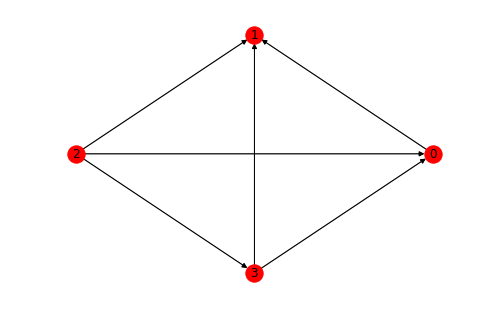

In [48]:
pos = nx.shell_layout(G_nx)
nx.draw(G_nx,pos, with_labels=True)
nx.draw_networkx_edges(G_nx, pos, width=1.0, alpha=0.5)

In [49]:
source_idx_list = np.arange(num_entities)
target_idx_list = [1]

In [50]:
source_idx_list

array([0, 1, 2, 3])

In [51]:
target_idx_list

[1]

In [52]:
def get_dict_paths(G, source_idx_list, target_idx_list):
    dict_paths = {}
    count = 0
    for source_idx in source_idx_list:
        for target_idx in target_idx_list:
            print("source_idx: ",source_idx,", target_idx: ",target_idx)
            p1 = [source_idx,target_idx]
            #
            list_e_paths = []
            for path in nx.all_simple_paths(G, source=source_idx, target=target_idx):
                print(path)
                if not p1 == path:
                    list_e_paths.append(path)
            if not [p1] == list_e_paths and len(list_e_paths) > 0:
                dict_paths[count] = {
                    "p1": p1,
                    "p2": list_e_paths
                }
            count+=1
            print("#")
    return dict_paths

In [53]:
get_dict_paths(G_nx, source_idx_list, target_idx_list)

source_idx:  0 , target_idx:  1
[0, 1]
#
source_idx:  1 , target_idx:  1
#
source_idx:  2 , target_idx:  1
[2, 0, 1]
[2, 1]
[2, 3, 0, 1]
[2, 3, 1]
#
source_idx:  3 , target_idx:  1
[3, 0, 1]
[3, 1]
#


{2: {'p1': [2, 1], 'p2': [[2, 0, 1], [2, 3, 0, 1], [2, 3, 1]]},
 3: {'p1': [3, 1], 'p2': [[3, 0, 1]]}}

In [54]:
get_dict_paths(G_nx, target_idx_list, source_idx_list)

source_idx:  1 , target_idx:  0
#
source_idx:  1 , target_idx:  1
#
source_idx:  1 , target_idx:  2
#
source_idx:  1 , target_idx:  3
#


{}

In [55]:
def get_dict_paths_x(G, X_meta, source_idx_list, target_idx_list, \
                    ):
    dict_paths = get_dict_paths(G, source_idx_list, target_idx_list)
    dict_paths_x = {}
    for path_id in dict_paths:
        #print("path_id: ",path_id)
        cur_dict_path = dict_paths[path_id]
        #p1
        p1_e_list = cur_dict_path["p1"]
        #
        p1_row_e = "e"+str(p1_e_list[0])
        p1_col_e = "e"+str(p1_e_list[1])
        #
        dict_paths_x[path_id] = {}
        for x_id in X_meta.keys():
            if (p1_row_e == X_meta[x_id][0]) and (p1_col_e == X_meta[x_id][1]):
                dict_paths_x[path_id]["p1"] = x_id
                break
        if "p1" in dict_paths_x[path_id].keys():
            #p2
            p2_e_list = cur_dict_path["p2"]
            #
            dict_paths_x[path_id]["p2"] = []
            for cur_p2_list in p2_e_list:
                i = 0
                p2_row_e = "e"+str(cur_p2_list[i])
                temp_list = []
                for i in np.arange(1,len(cur_p2_list)):
                    p2_col_e = "e"+str(cur_p2_list[i])
                    #
                    for x_id in X_meta.keys():
                        if ((p2_row_e == X_meta[x_id][0]) and (p2_col_e == X_meta[x_id][1])) or \
                           ((p2_row_e == X_meta[x_id][1]) and (p2_col_e == X_meta[x_id][0])):
                            temp_list.append(x_id)
                            break
                    #
                    p2_row_e = p2_col_e
                if not temp_list == [dict_paths_x[path_id]["p1"]]:
                    dict_paths_x[path_id]["p2"].append(temp_list)
    return dict_paths, dict_paths_x

In [56]:
dict_paths, dict_paths_x = get_dict_paths_x(G_nx, X_meta, source_idx_list, target_idx_list)

source_idx:  0 , target_idx:  1
[0, 1]
#
source_idx:  1 , target_idx:  1
#
source_idx:  2 , target_idx:  1
[2, 0, 1]
[2, 1]
[2, 3, 0, 1]
[2, 3, 1]
#
source_idx:  3 , target_idx:  1
[3, 0, 1]
[3, 1]
#


In [57]:
dict_paths

{2: {'p1': [2, 1], 'p2': [[2, 0, 1], [2, 3, 0, 1], [2, 3, 1]]},
 3: {'p1': [3, 1], 'p2': [[3, 0, 1]]}}

In [58]:
dict_paths_x

{2: {'p1': 'X4', 'p2': [['X3', 'X1'], ['X6', 'X7', 'X1'], ['X6', 'X8']]},
 3: {'p1': 'X8', 'p2': [['X7', 'X1']]}}

In [59]:
X_meta

{'X0': ['e0', 'e0'],
 'X1': ['e0', 'e1'],
 'X2': ['e1', 'e1'],
 'X3': ['e2', 'e0'],
 'X4': ['e2', 'e1'],
 'X5': ['e2', 'e2'],
 'X6': ['e2', 'e3'],
 'X7': ['e3', 'e0'],
 'X8': ['e3', 'e1'],
 'X9': ['e3', 'e3']}

In [60]:
#prune dict_paths_x and dict_paths_x
list_shortist = []
for path_id in dict_paths_x:
    if len(dict_paths_x[path_id]) > 0:
        list_shortist.append(path_id)

In [61]:
list_shortist

[2, 3]

In [62]:
dict_paths_x_temp = {}
dict_paths_temp = {}
for path_id in list_shortist:
    dict_paths_x_temp[path_id] = dict_paths_x[path_id]
    dict_paths_temp[path_id] = dict_paths[path_id]

In [63]:
pp.pprint(dict_paths_x_temp)

{   2: {'p1': 'X4', 'p2': [['X3', 'X1'], ['X6', 'X7', 'X1'], ['X6', 'X8']]},
    3: {'p1': 'X8', 'p2': [['X7', 'X1']]}}


In [64]:
pp.pprint(dict_paths_temp)

{   2: {'p1': [2, 1], 'p2': [[2, 0, 1], [2, 3, 0, 1], [2, 3, 1]]},
    3: {'p1': [3, 1], 'p2': [[3, 0, 1]]}}


In [65]:
#prune further ST only x path > len 1 is considered

In [66]:
dict_paths_x_temp_pruned = {}
dict_e_paths_idx = {}
for cur_path_id in dict_paths_x_temp.keys():
    print("cur_path_id: ",cur_path_id)
    dict_e_paths_idx[cur_path_id] = []
    #
    cur_path_dict = dict_paths_x_temp[cur_path_id]
    cur_path_p1 = cur_path_dict["p1"]
    cur_path_p2 = cur_path_dict["p2"]
    cur_path_p2_pruned = []
    idx = 0
    for temp_p2_path in cur_path_p2:
        if len(np.unique(temp_p2_path)) > 1:
            is_found = False
            for temp_path_so_far in cur_path_p2_pruned:
                print("set(temp_path_so_far): ",set(temp_path_so_far))
                print("set(temp_p2_path): ",set(temp_p2_path))
                print("len(set(temp_path_so_far) - set(temp_p2_path)): ",len(set(temp_path_so_far) - set(temp_p2_path)))
                print("not len(set(temp_path_so_far) - set(temp_p2_path)) > 0: ",not len(set(temp_path_so_far) - set(temp_p2_path)) > 0)
                if not len(set(temp_path_so_far) - set(temp_p2_path)) > 0:
                    is_found = True
                    break
            print("is_found: ",is_found)
            print("#")
            if not is_found:
                cur_path_p2_pruned.append(temp_p2_path)
                dict_e_paths_idx[cur_path_id].append(idx)
        idx+=1
    #
    dict_path_pruned_temp = {}
    dict_path_pruned_temp["p1"] = cur_path_p1
    dict_path_pruned_temp["p2"] = cur_path_p2_pruned
    dict_paths_x_temp_pruned[cur_path_id] = dict_path_pruned_temp

cur_path_id:  2
is_found:  False
#
set(temp_path_so_far):  {'X1', 'X3'}
set(temp_p2_path):  {'X7', 'X6', 'X1'}
len(set(temp_path_so_far) - set(temp_p2_path)):  1
not len(set(temp_path_so_far) - set(temp_p2_path)) > 0:  False
is_found:  False
#
set(temp_path_so_far):  {'X1', 'X3'}
set(temp_p2_path):  {'X6', 'X8'}
len(set(temp_path_so_far) - set(temp_p2_path)):  2
not len(set(temp_path_so_far) - set(temp_p2_path)) > 0:  False
set(temp_path_so_far):  {'X7', 'X6', 'X1'}
set(temp_p2_path):  {'X6', 'X8'}
len(set(temp_path_so_far) - set(temp_p2_path)):  2
not len(set(temp_path_so_far) - set(temp_p2_path)) > 0:  False
is_found:  False
#
cur_path_id:  3
is_found:  False
#


In [67]:
pp.pprint(dict_paths_x_temp_pruned)

{   2: {'p1': 'X4', 'p2': [['X3', 'X1'], ['X6', 'X7', 'X1'], ['X6', 'X8']]},
    3: {'p1': 'X8', 'p2': [['X7', 'X1']]}}


In [68]:
dict_e_paths_idx

{2: [0, 1, 2], 3: [0]}

In [69]:
dict_paths_temp

{2: {'p1': [2, 1], 'p2': [[2, 0, 1], [2, 3, 0, 1], [2, 3, 1]]},
 3: {'p1': [3, 1], 'p2': [[3, 0, 1]]}}

In [70]:
dict_paths_temp_pruned = {}
for cur_path_id in dict_paths_temp.keys():
    print("cur_path_id: ",cur_path_id)
    cur_path_dict = dict_paths_temp[cur_path_id]
    cur_path_p1 = cur_path_dict["p1"]
    cur_path_p2 = cur_path_dict["p2"]    
    cur_path_p2_pruned = []
    idx = 0
    for temp_p2_path in cur_path_p2:
        if idx in dict_e_paths_idx[cur_path_id]:
            cur_path_p2_pruned.append(temp_p2_path) 
        idx+=1
    #
    dict_path_pruned_temp = {}
    dict_path_pruned_temp["p1"] = cur_path_p1
    dict_path_pruned_temp["p2"] = cur_path_p2_pruned
    dict_paths_temp_pruned[cur_path_id] = dict_path_pruned_temp

cur_path_id:  2
cur_path_id:  3


In [71]:
dict_paths_temp_pruned

{2: {'p1': [2, 1], 'p2': [[2, 0, 1], [2, 3, 0, 1], [2, 3, 1]]},
 3: {'p1': [3, 1], 'p2': [[3, 0, 1]]}}

In [72]:
dict_paths_x = dict_paths_x_temp_pruned 
dict_paths = dict_paths_temp_pruned

In [73]:
# #prefix "e" and expand p2 to separate paths
# dict_paths_temp = {}
# for path_id in dict_paths:
#     dict_paths_temp[path_id] = {}
#     #p1
#     temp_list = []
#     for e_id in dict_paths[path_id]["p1"]:
#         temp_list.append("e"+str(e_id))
#     dict_paths_temp[path_id]["p1"] = temp_list
#     #p2
#     temp_list1 = []
#     for cur_temp_list in dict_paths[path_id]["p2"]:
#         temp_list2 = []
#         for e_id in cur_temp_list:
#             temp_list2.append("e"+str(e_id))
#         temp_list1.append(temp_list2)
#     dict_paths_temp[path_id]["p2"] = temp_list1
# dict_paths = dict_paths_temp

In [74]:
#prefix "e" and expand p2 to separate paths
dict_paths_temp = {}
for path_id in dict_paths:
    dict_paths_temp[path_id] = {}
    #p1
    temp_list = []
    for e_id in dict_paths[path_id]["p1"]:
        temp_list.append("e"+str(e_id))
    dict_paths_temp[path_id]["p1"] = temp_list
    #p2
    temp_dict1 = {}
    count = 0
    for cur_temp_list in dict_paths[path_id]["p2"]:
        temp_list1 = []
        for e_id in cur_temp_list:
            temp_list1.append("e"+str(e_id))
        temp_dict1[count] = temp_list1
        count+=1
    dict_paths_temp[path_id]["p2"] = temp_dict1
dict_paths = dict_paths_temp

In [75]:
pp.pprint(dict_paths)

{   2: {   'p1': ['e2', 'e1'],
           'p2': {   0: ['e2', 'e0', 'e1'],
                     1: ['e2', 'e3', 'e0', 'e1'],
                     2: ['e2', 'e3', 'e1']}},
    3: {'p1': ['e3', 'e1'], 'p2': {0: ['e3', 'e0', 'e1']}}}


In [76]:
pp.pprint(dict_paths_x)

{   2: {'p1': 'X4', 'p2': [['X3', 'X1'], ['X6', 'X7', 'X1'], ['X6', 'X8']]},
    3: {'p1': 'X8', 'p2': [['X7', 'X1']]}}


In [77]:
#expand p2 in dict_paths_x
temp_dict_path_x = {}
for temp_path_id in dict_paths_x:
    temp_dict_path_x[temp_path_id] = {}
    if len(dict_paths_x[temp_path_id]) > 0:
        #p1
        temp_dict_path_x[temp_path_id]["p1"] = dict_paths_x[temp_path_id]["p1"]
        #p2
        temp_dict = {}
        count = 0
        for temp_list in dict_paths_x[temp_path_id]["p2"]:
            temp_dict[count] = temp_list
            count+=1
        temp_dict_path_x[temp_path_id]["p2"] = temp_dict
dict_paths_x = temp_dict_path_x

In [78]:
pp.pprint(dict_paths_x)

{   2: {   'p1': 'X4',
           'p2': {0: ['X3', 'X1'], 1: ['X6', 'X7', 'X1'], 2: ['X6', 'X8']}},
    3: {'p1': 'X8', 'p2': {0: ['X7', 'X1']}}}


In [79]:
#transform dict_paths
dict_temp_paths = {}
for path_id in dict_paths:
    temp_dict = {}
    for temp_p2_path_id in dict_paths[path_id]["p2"]:
        temp_dict[temp_p2_path_id] = {
            "p1": dict_paths[path_id]["p1"],
            "p2": dict_paths[path_id]["p2"][temp_p2_path_id]
        }
    dict_temp_paths[path_id] = temp_dict
dict_paths = dict_temp_paths

In [80]:
pp.pprint(dict_paths)

{   2: {   0: {'p1': ['e2', 'e1'], 'p2': ['e2', 'e0', 'e1']},
           1: {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e0', 'e1']},
           2: {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e1']}},
    3: {0: {'p1': ['e3', 'e1'], 'p2': ['e3', 'e0', 'e1']}}}


In [81]:
#transfor dict_paths_x
dict_temp_paths_x = {}
for path_id in dict_paths_x:
    temp_dict = {}
    for temp_p2_path_id in dict_paths_x[path_id]["p2"]:
        temp_dict[temp_p2_path_id] = {
            "p1": dict_paths_x[path_id]["p1"],
            "p2": dict_paths_x[path_id]["p2"][temp_p2_path_id]
        }
    dict_temp_paths_x[path_id] = temp_dict
dict_paths_x = dict_temp_paths_x

In [82]:
pp.pprint(dict_paths_x)

{   2: {   0: {'p1': 'X4', 'p2': ['X3', 'X1']},
           1: {'p1': 'X4', 'p2': ['X6', 'X7', 'X1']},
           2: {'p1': 'X4', 'p2': ['X6', 'X8']}},
    3: {0: {'p1': 'X8', 'p2': ['X7', 'X1']}}}


In [83]:
#out

In [84]:
dname_out = "./../../out_clust/pubmed_heuristic/version_"+version_no+"/"

In [85]:
fname_clust_labels = dname_out+"dict_c_clust_labels.pkl"
fname_A = dname_out+"dict_A.pkl"
fname_X_prime = dname_out+"dict_recons_X.pkl"
fname_Y_prime = dname_out+"dict_recons_Y.pkl"
fname_I_ortho = dname_out+"dict_I_ortho.pkl"
fname_U = dname_out+"dict_U.pkl"
fname_mu = dname_out+"dict_mu.pkl"

In [86]:
dict_clust_labels = pkl.load(open(fname_clust_labels,"rb"))
dict_A = pkl.load(open(fname_A,"rb"))
dict_X_prime = pkl.load(open(fname_X_prime,"rb"))
dict_Y_prime = pkl.load(open(fname_Y_prime,"rb"))
dict_I_ortho = pkl.load(open(fname_I_ortho,"rb"))
dict_U = pkl.load(open(fname_U,"rb"))
dict_mu = pkl.load(open(fname_mu,"rb"))

In [87]:
def mode_xid(dict_with_key_xid):
    dict_temp = {}
    for xid in dict_with_key_xid.keys():
        temp_xid = dict_map_xid[xid]
        dict_temp[temp_xid] = dict_with_key_xid[xid]
    return dict_temp

def mode_eid_xid(dict_with_key_eid_xid):
    dict_temp = {}
    for eid_xid in dict_with_key_eid_xid.keys():
        eid = eid_xid.split("_")[0]
        xid = eid_xid.split("_")[1]
        temp_xid = dict_map_xid[xid]
        temp_eid = dict_map_eid[eid]
        temp_eid_xid = temp_eid+"_"+temp_xid
        dict_temp[temp_eid_xid] = dict_with_key_eid_xid[eid_xid]
    return dict_temp

def mode_eid(dict_with_key_eid):
    dict_temp = {}
    for eid in dict_with_key_eid.keys():
        temp_eid = dict_map_eid[eid]
        dict_temp[temp_eid] = dict_with_key_eid[eid]
    return dict_temp

In [88]:
dict_clust_labels = mode_eid(dict_clust_labels)

In [89]:
dict_A = mode_xid(dict_A)

In [90]:
dict_X_prime = mode_xid(dict_X_prime)

In [91]:
dict_Y_prime = mode_eid_xid(dict_Y_prime)

In [92]:
dict_I_ortho = mode_eid(dict_I_ortho)

In [93]:
dict_U = mode_eid(dict_U)

In [94]:
dict_mu = mode_eid_xid(dict_mu)

In [95]:
#sanity check - start

In [96]:
dict_A.keys()

dict_keys(['X4', 'X5', 'X3', 'X7', 'X6', 'X8', 'X9', 'X0', 'X1', 'X2'])

In [97]:
dict_A["X0"]

array([[ 45.595837  ,  10.398006  ,   1.785453  ,   6.203114  ,
         13.44783   ,   1.4088037 ,   1.0581007 ,   1.0452437 ],
       [ -9.1939745 ,  -8.697322  , -11.01373   ,  -6.805213  ,
         -8.567859  ,  -6.716199  ,  -7.721046  ,  -6.1246996 ],
       [ -0.7444142 ,   9.854951  ,  27.923466  ,   2.6537592 ,
          3.439765  ,  -0.12557644,   1.5064617 ,  -0.81576496],
       [  0.15779752,   0.89088017,  -0.79585004,  13.610084  ,
          0.5149938 ,  -1.6596503 ,  -2.269177  ,  -1.120863  ],
       [  1.6567107 ,   1.2291684 ,   1.1335671 ,   3.2667882 ,
          9.9100485 ,  -0.63470936,  -1.0389456 ,  -0.5155338 ],
       [  0.74470997,   4.761139  ,   3.1183796 ,   1.1058965 ,
          4.8714094 ,  43.884243  ,   0.42214277,   2.5420504 ],
       [  3.0445867 ,  14.716202  ,  13.170891  ,   0.2722254 ,
          6.315106  ,   2.1883793 ,  47.35556   ,   2.2559707 ],
       [  0.1986087 ,   1.8289092 ,  -0.12222118,   1.6024945 ,
          0.7781936 ,   1.8869123

In [98]:
np.round(dict_A["X0"])

array([[ 46.,  10.,   2.,   6.,  13.,   1.,   1.,   1.],
       [ -9.,  -9., -11.,  -7.,  -9.,  -7.,  -8.,  -6.],
       [ -1.,  10.,  28.,   3.,   3.,  -0.,   2.,  -1.],
       [  0.,   1.,  -1.,  14.,   1.,  -2.,  -2.,  -1.],
       [  2.,   1.,   1.,   3.,  10.,  -1.,  -1.,  -1.],
       [  1.,   5.,   3.,   1.,   5.,  44.,   0.,   3.],
       [  3.,  15.,  13.,   0.,   6.,   2.,  47.,   2.],
       [  0.,   2.,  -0.,   2.,   1.,   2.,  -0.,  44.]], dtype=float32)

In [99]:
#A_sr = np.abs(dict_A["X1"].T)
A_sr = dict_A["X0"].T
A_temp = np.zeros(A_sr.shape)
for i in np.arange(A_temp.shape[0]):
    j = np.argmax(A_sr[i,:])
    A_temp[i,j] = 1
A_temp    

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [100]:
np.round(np.dot(dict_I_ortho["e0"].T, dict_I_ortho["e0"]))

array([[ 1.,  0., -0.,  0., -0., -0., -0., -0.],
       [ 0.,  1.,  0., -0.,  0.,  0., -0., -0.],
       [-0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0., -0.,  0.,  1., -0., -0.,  0.,  0.],
       [-0.,  0.,  0., -0.,  1.,  0., -0.,  0.],
       [-0.,  0.,  0., -0.,  0.,  1., -0., -0.],
       [-0., -0., -0.,  0., -0., -0.,  1.,  0.],
       [-0., -0., -0.,  0.,  0., -0.,  0.,  1.]], dtype=float32)

In [101]:
#sanity check - end

In [102]:
dict_clust_labels

{'e0': array([1, 1, 4, ..., 3, 4, 1], dtype=int32),
 'e1': array([1, 1, 1, ..., 1, 1, 5], dtype=int32),
 'e2': array([5, 5, 5, ..., 5, 5, 5], dtype=int32),
 'e3': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 1, 1, 4, 1, 0, 1, 1, 1, 5,
        1, 1, 1, 4, 1, 0, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
        1, 5, 1, 5, 1, 1, 1, 1, 5, 1, 7, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1,
        5, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 7, 1, 1, 1, 5, 1, 1,
        5, 1, 5, 1, 3, 7, 5, 1, 1, 1, 1, 5, 1, 7, 1, 1, 1, 1, 1, 1, 1, 3,
        5, 1, 7, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 1, 1, 1, 1, 1,
        3, 7, 1, 1, 5, 1, 1, 1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 5, 5, 1, 1, 5, 7, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 3, 6, 1, 1, 1, 1, 1, 5, 1, 1, 7, 1, 0, 1, 1, 7, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 5, 1, 3, 1, 1, 0, 1, 5, 1, 5,
        1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 3

In [103]:
def get_cluster_num_idx(dict_clust_labels,e_id,num_clusters):
    p_clust_id_list = dict_clust_labels[e_id]
#     p_clust_id_list = []
#     for i in np.arange(U.shape[0]):
#         temp_arr = U[i]
#         p_clust_id_list.append(np.argmax(temp_arr))
    #
    p_clust_id_num_dict = {}
    p_clust_id_idx_dict = {}
    for j in np.arange(num_clusters[e_id]):
        temp_clust_j = np.array(p_clust_id_list) == j
        temp_clust_j_idx = np.arange(p_clust_id_list.shape[0])[temp_clust_j]
        num_p = np.sum(temp_clust_j)
        print("cluster: ",j,", #", num_p)
        p_clust_id_num_dict[j] = num_p
        p_clust_id_idx_dict[j] = temp_clust_j_idx     
    return p_clust_id_num_dict, p_clust_id_idx_dict,p_clust_id_list

In [104]:
dict_entity_cluster_info = {}
for e_id in G.keys():
    print("e_id: ",e_id)
    temp_num, temp_idx, temp_pred_idx = get_cluster_num_idx(dict_clust_labels,e_id,dict_num_clusters)
    dict_entity_cluster_info[e_id] = {"num":temp_num,"idx":temp_idx,"temp_pred_idx":temp_pred_idx}

e_id:  e3
cluster:  0 , # 13
cluster:  1 , # 471
cluster:  2 , # 2
cluster:  3 , # 37
cluster:  4 , # 3
cluster:  5 , # 61
cluster:  6 , # 3
cluster:  7 , # 18
e_id:  e0
cluster:  0 , # 63
cluster:  1 , # 1956
cluster:  2 , # 155
cluster:  3 , # 128
cluster:  4 , # 199
cluster:  5 , # 43
cluster:  6 , # 56
cluster:  7 , # 34
e_id:  e2
cluster:  0 , # 78
cluster:  1 , # 76
cluster:  2 , # 60
cluster:  3 , # 32
cluster:  4 , # 42
cluster:  5 , # 5293
cluster:  6 , # 41
cluster:  7 , # 38
e_id:  e1
cluster:  0 , # 120
cluster:  1 , # 3407
cluster:  2 , # 123
cluster:  3 , # 309
cluster:  4 , # 134
cluster:  5 , # 163
cluster:  6 , # 117
cluster:  7 , # 32


In [105]:
# Find cluster chains across each of the paths in dict_paths
# Combine the info with dict_paths_x to create 
# dict_paths_cc

In [106]:
pp.pprint(dict_paths)

{   2: {   0: {'p1': ['e2', 'e1'], 'p2': ['e2', 'e0', 'e1']},
           1: {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e0', 'e1']},
           2: {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e1']}},
    3: {0: {'p1': ['e3', 'e1'], 'p2': ['e3', 'e0', 'e1']}}}


In [107]:
#print paths
for temp_path_id1 in dict_paths.keys():
    for temp_path_id2 in dict_paths[temp_path_id1].keys():
        temp_dict = dict_paths[temp_path_id1][temp_path_id2]
        p1 = temp_dict["p1"]
        p2 = temp_dict["p2"]
        #
        list_p1 = []
        for eid in p1:
            list_p1.append(eid.replace("e",""))    
        list_p1.append(" ")
        list_p1.append(str(1.0 / (len(list_p1)-1)))
        print("".join(list_p1))
        #
        list_p2 = []
        for eid in p2:
            list_p2.append(eid.replace("e",""))    
        list_p2.append(" ")
        list_p2.append(str(1.0 / (len(list_p2)-1)))
        print("".join(list_p2))
        

21 0.5
201 0.3333333333333333
21 0.5
2301 0.25
21 0.5
231 0.3333333333333333
31 0.5
301 0.3333333333333333


In [108]:
pp.pprint(dict_paths_x)

{   2: {   0: {'p1': 'X4', 'p2': ['X3', 'X1']},
           1: {'p1': 'X4', 'p2': ['X6', 'X7', 'X1']},
           2: {'p1': 'X4', 'p2': ['X6', 'X8']}},
    3: {0: {'p1': 'X8', 'p2': ['X7', 'X1']}}}


In [109]:
dict_paths[path_id]

{0: {'p1': ['e3', 'e1'], 'p2': ['e3', 'e0', 'e1']}}

In [110]:
#for each path
dict_path_cc_info = {}
for path_id in dict_paths:
    for chain_template_id in dict_paths[path_id]:
        cur_key = (path_id, chain_template_id)
        cur_chain_template = dict_paths[path_id][chain_template_id]
        cur_chain_template_x = dict_paths_x[path_id][chain_template_id]
        dict_path_cc_info[cur_key] = {
            "path_id":path_id,
            "chain_template_id": chain_template_id,
            "cur_chain_template_e": cur_chain_template,
            "cur_chain_template_x": cur_chain_template_x
        }    

In [111]:
dict_path_cc_info

{(2, 0): {'chain_template_id': 0,
  'cur_chain_template_e': {'p1': ['e2', 'e1'], 'p2': ['e2', 'e0', 'e1']},
  'cur_chain_template_x': {'p1': 'X4', 'p2': ['X3', 'X1']},
  'path_id': 2},
 (2, 1): {'chain_template_id': 1,
  'cur_chain_template_e': {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e0', 'e1']},
  'cur_chain_template_x': {'p1': 'X4', 'p2': ['X6', 'X7', 'X1']},
  'path_id': 2},
 (2, 2): {'chain_template_id': 2,
  'cur_chain_template_e': {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e1']},
  'cur_chain_template_x': {'p1': 'X4', 'p2': ['X6', 'X8']},
  'path_id': 2},
 (3, 0): {'chain_template_id': 0,
  'cur_chain_template_e': {'p1': ['e3', 'e1'], 'p2': ['e3', 'e0', 'e1']},
  'cur_chain_template_x': {'p1': 'X8', 'p2': ['X7', 'X1']},
  'path_id': 3}}

In [112]:
df_entity_reln

,LINK,START,END,MEANING
0,0,0,0,GENE-and-GENE
1,1,0,1,GENE-causing-DISEASE
2,2,1,1,DISEASE-and-DISEASE
3,3,2,0,CHEMICAL-in-GENE
4,4,2,1,CHEMICAL-in-DISEASE
5,5,2,2,CHEMICAL-and-CHEMICAL
6,6,2,3,CHEMICAL-in-SPECIES
7,7,3,0,SPECIES-with-GENE
8,8,3,1,SPECIES-with-DISEASE
9,9,3,3,SPECIES-and-SPECIES


In [113]:
dict_path_cc = {}
for cur_cc_info_id in dict_path_cc_info:
    cur_cc_info = dict_path_cc_info[cur_cc_info_id]
    cur_chain_template_e = cur_cc_info["cur_chain_template_e"]
    cur_chain_template_x = cur_cc_info["cur_chain_template_x"]
    #
    dict_path_cc[cur_cc_info_id] = {}
    #
    ########### p1 ###################
    dict_temp_p1 = {}
    p1_e_list = cur_chain_template_e["p1"]
    p1_x = cur_chain_template_x["p1"]
    if is_abs_A:
        p1_A = np.abs(dict_A[p1_x])
        scaler1 = StandardScaler()
        p1_A = np.abs(scaler1.fit_transform(p1_A))
    else:
        p1_A = dict_A[p1_x]
        scaler1 = StandardScaler()
        p1_A = scaler1.fit_transform(p1_A)
    #
    p1_row_e = p1_e_list[0]
    p1_col_e = p1_e_list[1]
    #
    seq_no = 0
    num_clust_p1_row_e = dict_num_clusters[p1_row_e]
    for row_clust_idx in np.arange(num_clust_p1_row_e):
        #process this row cluster if its not empty
        if dict_entity_cluster_info[p1_row_e]["num"][row_clust_idx] > 0:
            # find the asso column cluster
            temp_idx_list = list(np.argsort(p1_A[row_clust_idx,:]))
            temp_idx_list.reverse()
            for temp_idx in temp_idx_list:
                if dict_entity_cluster_info[p1_col_e]["num"][temp_idx] > 0:
                    col_clust_idx = temp_idx
                    break
            #
            dict_temp_p1["clust-"+str(row_clust_idx)] = {
                                  seq_no: {
                                  "x_id":p1_x,\
                                  "row_e_id": p1_row_e,\
                                  "col_e_id": p1_col_e,\
                                  "row_clust_idx": row_clust_idx,\
                                  "col_clust_idx":col_clust_idx
                                  }
                                } 
    ########### p2 ###################
    dict_temp_p2 = {}
    p2_e_list = cur_chain_template_e["p2"]
    p2_x_list = cur_chain_template_x["p2"]
    print("p2_e_list: ",p2_e_list)
    print("p2_x_list: ",p2_x_list)
    print("#")
    tot_num_matrices_p2 = len(p2_x_list)
    #
    p2_start_row_e = p2_e_list[0]
    num_clust_p2_row_e = dict_num_clusters[p2_start_row_e]
    for clust_id in np.arange(num_clust_p2_row_e):
        dict_temp_cc = {}
        i = 0
        p2_row_e = p2_e_list[i]
        row_clust_idx = clust_id
        for seq_no in np.arange(tot_num_matrices_p2):
            i+=1
            p2_x = p2_x_list[seq_no]
            p2_col_e = p2_e_list[i]
            #
            is_transp = False
            print("Bef: p2_x: ",p2_x,", X_meta[p2_x]: ",X_meta[p2_x]," | p2_row_e: ",p2_row_e,", p2_col_e: ",p2_col_e," | is_transp: ",is_transp)
            if not (X_meta[p2_x][0] == p2_row_e):
                temp_row_e = p2_row_e
                temp_col_e = p2_col_e
                p2_row_e = temp_col_e
                p2_col_e = temp_row_e
                is_transp = True
            #
            print("Aft: p2_x: ",p2_x,", X_meta[p2_x]: ",X_meta[p2_x]," | p2_row_e: ",p2_row_e,", p2_col_e: ",p2_col_e," | is_transp: ",is_transp)
            assert X_meta[p2_x][0] == p2_row_e
            assert X_meta[p2_x][1] == p2_col_e
            #
            if is_abs_A:
                if not is_transp:
                    p2_A = dict_A[p2_x]
                else:
                    p2_A = dict_A[p2_x].T
                #
                scaler1 = StandardScaler()
                p2_A = np.abs(scaler1.fit_transform(p2_A))
            else:
                if not is_transp:
                    p2_A = dict_A[p2_x]
                else:
                    p2_A = dict_A[p2_x].T
                #
                scaler1 = StandardScaler()
                p2_A = scaler1.fit_transform(p2_A)
            #
            # find the asso column cluster
            temp_idx_list = list(np.argsort(p2_A[row_clust_idx,:]))
            temp_idx_list.reverse()
            for temp_idx in temp_idx_list:
                if dict_entity_cluster_info[p2_col_e]["num"][temp_idx] > 0:
                    col_clust_idx = temp_idx
                    break        
            #
            dict_temp_cc[seq_no] = {
                          "x_id":p2_x,\
                          "row_e_id": p2_row_e,\
                          "col_e_id": p2_col_e,\
                          "row_clust_idx": row_clust_idx,\
                          "col_clust_idx":col_clust_idx,\
                          "seq_num":seq_no,\
                          "tot_num_matrices_p2":tot_num_matrices_p2            
            }
            row_clust_idx = col_clust_idx
            if not is_transp:
                p2_row_e = p2_col_e
#             else:
#                 p2_row_e = p2_row_e
        #for every clust_id add as cc
        dict_temp_p2["clust-"+str(clust_id)] = dict_temp_cc
    ####################
    dict_path_cc[cur_cc_info_id]["p1"] = dict_temp_p1
    dict_path_cc[cur_cc_info_id]["p2"] = dict_temp_p2

p2_e_list:  ['e2', 'e0', 'e1']
p2_x_list:  ['X3', 'X1']
#
Bef: p2_x:  X3 , X_meta[p2_x]:  ['e2', 'e0']  | p2_row_e:  e2 , p2_col_e:  e0  | is_transp:  False
Aft: p2_x:  X3 , X_meta[p2_x]:  ['e2', 'e0']  | p2_row_e:  e2 , p2_col_e:  e0  | is_transp:  False
Bef: p2_x:  X1 , X_meta[p2_x]:  ['e0', 'e1']  | p2_row_e:  e0 , p2_col_e:  e1  | is_transp:  False
Aft: p2_x:  X1 , X_meta[p2_x]:  ['e0', 'e1']  | p2_row_e:  e0 , p2_col_e:  e1  | is_transp:  False
Bef: p2_x:  X3 , X_meta[p2_x]:  ['e2', 'e0']  | p2_row_e:  e2 , p2_col_e:  e0  | is_transp:  False
Aft: p2_x:  X3 , X_meta[p2_x]:  ['e2', 'e0']  | p2_row_e:  e2 , p2_col_e:  e0  | is_transp:  False
Bef: p2_x:  X1 , X_meta[p2_x]:  ['e0', 'e1']  | p2_row_e:  e0 , p2_col_e:  e1  | is_transp:  False
Aft: p2_x:  X1 , X_meta[p2_x]:  ['e0', 'e1']  | p2_row_e:  e0 , p2_col_e:  e1  | is_transp:  False
Bef: p2_x:  X3 , X_meta[p2_x]:  ['e2', 'e0']  | p2_row_e:  e2 , p2_col_e:  e0  | is_transp:  False
Aft: p2_x:  X3 , X_meta[p2_x]:  ['e2', 'e0']  | p2_

In [114]:
pp.pprint(dict_path_cc)

{   (2, 0): {   'p1': {   'clust-0': {   0: {   'col_clust_idx': 1,
                                                'col_e_id': 'e1',
                                                'row_clust_idx': 0,
                                                'row_e_id': 'e2',
                                                'x_id': 'X4'}},
                          'clust-1': {   0: {   'col_clust_idx': 3,
                                                'col_e_id': 'e1',
                                                'row_clust_idx': 1,
                                                'row_e_id': 'e2',
                                                'x_id': 'X4'}},
                          'clust-2': {   0: {   'col_clust_idx': 7,
                                                'col_e_id': 'e1',
                                                'row_clust_idx': 2,
                                                'row_e_id': 'e2',
                                                'x_id': 'X4'}},
    

                          'clust-1': {   0: {   'col_clust_idx': 5,
                                                'col_e_id': 'e3',
                                                'row_clust_idx': 1,
                                                'row_e_id': 'e2',
                                                'seq_num': 0,
                                                'tot_num_matrices_p2': 2,
                                                'x_id': 'X6'},
                                         1: {   'col_clust_idx': 3,
                                                'col_e_id': 'e1',
                                                'row_clust_idx': 5,
                                                'row_e_id': 'e3',
                                                'seq_num': 1,
                                                'tot_num_matrices_p2': 2,
                                                'x_id': 'X8'}},
                          'clust-2': {   0: {   'col_clust_idx': 

In [115]:
dict_path_cc.keys()

dict_keys([(2, 0), (2, 1), (2, 2), (3, 0)])

In [116]:
dict_path_cc[(2,0)].keys()

dict_keys(['p1', 'p2'])

In [117]:
dict_path_cc[(2,0)]["p1"].keys()

dict_keys(['clust-0', 'clust-1', 'clust-2', 'clust-3', 'clust-4', 'clust-5', 'clust-6', 'clust-7'])

In [118]:
dict_path_cc[(2,0)]["p2"].keys()

dict_keys(['clust-0', 'clust-1', 'clust-2', 'clust-3', 'clust-4', 'clust-5', 'clust-6', 'clust-7'])

In [119]:
pp.pprint(dict_path_cc_info)

{   (2, 0): {   'chain_template_id': 0,
                'cur_chain_template_e': {   'p1': ['e2', 'e1'],
                                            'p2': ['e2', 'e0', 'e1']},
                'cur_chain_template_x': {'p1': 'X4', 'p2': ['X3', 'X1']},
                'path_id': 2},
    (2, 1): {   'chain_template_id': 1,
                'cur_chain_template_e': {   'p1': ['e2', 'e1'],
                                            'p2': ['e2', 'e3', 'e0', 'e1']},
                'cur_chain_template_x': {'p1': 'X4', 'p2': ['X6', 'X7', 'X1']},
                'path_id': 2},
    (2, 2): {   'chain_template_id': 2,
                'cur_chain_template_e': {   'p1': ['e2', 'e1'],
                                            'p2': ['e2', 'e3', 'e1']},
                'cur_chain_template_x': {'p1': 'X4', 'p2': ['X6', 'X8']},
                'path_id': 2},
    (3, 0): {   'chain_template_id': 0,
                'cur_chain_template_e': {   'p1': ['e3', 'e1'],
                                            

In [120]:
#Scoring the CCs

In [121]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

def get_dist(X1, X2):
    d_list = np.diag(cosine_distances(X1,X2))
    #d = np.sqrt(np.sum(np.round(d_list,4)))
    d = np.mean(np.round(d_list,4))
    return d 

def get_dist_subspace(X1, X2, k=None, is_X1_orth=False, is_X2_orth=False):
    print("start - fn get_dist_subspace: ")
    print("X1.shape: ",X1.shape)
    print("X2.shape: ",X2.shape)
    if k == None:
        k1 = X1.shape[1]
        k2 = X2.shape[1]
        k = min(k1,k2)
        print("k1: ",k1,", k2: ",k2,", min(k1,k2): ",k)
    #
    if not is_X1_orth:
        u1, s, vh = np.linalg.svd(X1)
    if not is_X2_orth:
        u2, s, vh = np.linalg.svd(X2)
    #
    if k > u1.shape[1]:
        k = u1.shape[1]
    if k > u2.shape[1]:
        k = u2.shape[1]
    #
    X1_tilde = u1[:,0:k]
    X2_tilde = u2[:,0:k]
    #
    print("X1_tilde.shape: ",X1_tilde.shape)
    print("X2_tilde.shape: ",X2_tilde.shape)
    M = np.dot(X1_tilde, X2_tilde.T)
    print("M.shape: ",M.shape)
    u, s, vh = np.linalg.svd(M)
    d = np.sqrt(np.sum(1 - np.round(pow(s,2),4)))
    #d = np.mean(1 - np.round(pow(s,2),2))
    print("end - fn get_dist_subspace: ")
    return d    


In [122]:
#prep dict_X_prime
dict_X_prime_plus = {}
for temp_x_id in dict_X_prime:
    temp_row_e_id = X_meta[temp_x_id][0]
    temp_col_e_id = X_meta[temp_x_id][1]
    temp_plus_x_id = temp_row_e_id+"_"+temp_x_id
    temp_plus_x_id_transp = temp_col_e_id+"_"+temp_x_id
    dict_X_prime_plus[temp_plus_x_id] = dict_X_prime[temp_x_id]
    dict_X_prime_plus[temp_plus_x_id_transp] = dict_X_prime[temp_x_id].T

In [123]:
pp.pprint(dict_path_cc[(2,0)])

{   'p1': {   'clust-0': {   0: {   'col_clust_idx': 1,
                                    'col_e_id': 'e1',
                                    'row_clust_idx': 0,
                                    'row_e_id': 'e2',
                                    'x_id': 'X4'}},
              'clust-1': {   0: {   'col_clust_idx': 3,
                                    'col_e_id': 'e1',
                                    'row_clust_idx': 1,
                                    'row_e_id': 'e2',
                                    'x_id': 'X4'}},
              'clust-2': {   0: {   'col_clust_idx': 7,
                                    'col_e_id': 'e1',
                                    'row_clust_idx': 2,
                                    'row_e_id': 'e2',
                                    'x_id': 'X4'}},
              'clust-3': {   0: {   'col_clust_idx': 6,
                                    'col_e_id': 'e1',
                                    'row_clust_idx': 3,
                  

In [124]:
dict_path_cc_score = {}
for cur_path_id in dict_path_cc:
    dict_path_cc_score[cur_path_id] = {}
#
for cur_path_id in dict_path_cc:
    print("cur_path_id: ",cur_path_id)
    #
    cur_cc_set = dict_path_cc[cur_path_id]
    #
    cur_cc_set_p1 = cur_cc_set["p1"]
    cur_cc_set_p2 = cur_cc_set["p2"]
    #
    assert cur_cc_set_p1.keys() == cur_cc_set_p2.keys()
    #
    cur_clust_ids_list = list(cur_cc_set_p1.keys())
    #
    for cur_clust_id in cur_clust_ids_list:
        dict_path_cc_score[cur_path_id][cur_clust_id] = {}
    #
    for cur_clust_id in cur_clust_ids_list:
        print("cur_clust_id: ",cur_clust_id)
        print("p1")
        ####################### s1 #######################
        #s1 using p1 - prep
        assert len(cur_cc_set_p1[cur_clust_id]) == 1
        cur_dict_node = cur_cc_set_p1[cur_clust_id][0]

        cur_row_e_id = cur_dict_node["row_e_id"]
        cur_col_e_id = cur_dict_node["col_e_id"]

        cur_X_w_id = cur_dict_node["x_id"]
        #cur_X_w = X_data[cur_X_w_id] << not we are not using the original data matrix but the AEC recons
        cur_X_w_id_plus = cur_row_e_id+"_"+cur_X_w_id
        cur_X_w = dict_Y_prime[cur_X_w_id_plus]
        assert cur_X_w.shape[0] == dict_e_size[cur_row_e_id]
        assert cur_X_w.shape[1] == dict_e_size[cur_col_e_id]
        assert X_meta[cur_X_w_id][0] == cur_row_e_id
        assert X_meta[cur_X_w_id][1] == cur_col_e_id

        cur_row_clust_idx = cur_dict_node["row_clust_idx"]
        cur_col_clust_idx = cur_dict_node["col_clust_idx"]
        assert cur_row_clust_idx < dict_num_clusters[cur_row_e_id]
        assert cur_col_clust_idx < dict_num_clusters[cur_col_e_id]

        cur_row_e_clust_idx_list = dict_entity_cluster_info[cur_row_e_id]["idx"][cur_row_clust_idx]
        cur_col_e_clust_idx_list = dict_entity_cluster_info[cur_col_e_id]["idx"][cur_col_clust_idx]

        B_w = cur_X_w[cur_row_e_clust_idx_list,:][:,cur_col_e_clust_idx_list]
        assert B_w.shape[0] == len(cur_row_e_clust_idx_list)
        assert B_w.shape[1] == len(cur_col_e_clust_idx_list)

        cur_X_w_pred = dict_X_prime_plus[cur_X_w_id_plus]
        assert cur_X_w_pred.shape[0] == cur_X_w.shape[0]
        assert cur_X_w_pred.shape[1] == cur_X_w.shape[1]

        B_w_pred = cur_X_w_pred[cur_row_e_clust_idx_list,:][:,cur_col_e_clust_idx_list]
        assert B_w.shape[0] == B_w_pred.shape[0]
        assert B_w.shape[1] == B_w_pred.shape[1]
        
        #s1 using p1 
        s1 = get_dist(B_w, B_w_pred)
        
        ####################### s2 and s3 #######################
        print("p2")
        #s2 using p2's list 
        s2 = 0
        s3 = 0
        s3_comp_count = 0
        for seq_no in cur_cc_set_p2[cur_clust_id].keys():
            print("seq_no: ",seq_no)
            cur_dict_node_p2 = cur_cc_set_p2[cur_clust_id][seq_no]
            #print("cur_dict_node_p2: ")
            #pp.pprint(cur_dict_node_p2)
            #
            cur_row_e_id = cur_dict_node_p2["row_e_id"]
            cur_col_e_id = cur_dict_node_p2["col_e_id"]

            cur_X_a_id = cur_dict_node_p2["x_id"]
            #cur_X_a = X_data[cur_X_a_id] << not we are not using the original data matrix but the AEC recons
            cur_X_a_id_plus = cur_row_e_id+"_"+cur_X_a_id
            cur_X_a = dict_Y_prime[cur_X_a_id_plus]
            assert cur_X_a.shape[0] == dict_e_size[cur_row_e_id]
            assert cur_X_a.shape[1] == dict_e_size[cur_col_e_id]
            assert X_meta[cur_X_a_id][0] == cur_row_e_id
            assert X_meta[cur_X_a_id][1] == cur_col_e_id

            cur_row_clust_idx = cur_dict_node_p2["row_clust_idx"]
            cur_col_clust_idx = cur_dict_node_p2["col_clust_idx"]
            assert cur_row_clust_idx < dict_num_clusters[cur_row_e_id]
            assert cur_col_clust_idx < dict_num_clusters[cur_col_e_id]

            cur_row_e_clust_idx_list = dict_entity_cluster_info[cur_row_e_id]["idx"][cur_row_clust_idx]
            cur_col_e_clust_idx_list = dict_entity_cluster_info[cur_col_e_id]["idx"][cur_col_clust_idx]

            B_a = cur_X_a[cur_row_e_clust_idx_list,:][:,cur_col_e_clust_idx_list]
            assert B_a.shape[0] == len(cur_row_e_clust_idx_list)
            assert B_a.shape[1] == len(cur_col_e_clust_idx_list)

            cur_X_a_pred = dict_X_prime_plus[cur_X_a_id_plus]
            assert cur_X_a_pred.shape[0] == cur_X_a.shape[0]
            assert cur_X_a_pred.shape[1] == cur_X_a.shape[1]

            B_a_pred = cur_X_a_pred[cur_row_e_clust_idx_list,:][:,cur_col_e_clust_idx_list]
            assert B_a.shape[0] == B_a_pred.shape[0]
            assert B_a.shape[1] == B_a_pred.shape[1]
            #
            cur_seq_num = cur_dict_node_p2["seq_num"]
            cur_tot_num_mat = cur_dict_node_p2["tot_num_matrices_p2"]           
            #
            cur_s2 = get_dist(B_a, B_a_pred)
            s2 = s2 + cur_s2
            #if cur_tot_num_mat == (cur_seq_num+1):
            if cur_seq_num == 0:
                s3 = get_dist_subspace(B_a, B_w_pred,k=20)
                s3_comp_count+=1
        print("#")
        assert s3_comp_count == 1
        #
        print("s1: ",s1,", s2: ",s2,", s3: ",s3)
        alpha = 1.0
        beta = 1.0
        gamma = 1.0
        cur_score = (alpha * s1) - (beta * s2) - (gamma * s3)
        print("cur_score: ",cur_score)
        dict_path_cc_score[cur_path_id][cur_clust_id] = cur_score
        print("######")

cur_path_id:  (2, 0)
cur_clust_id:  clust-0
p1
p2
seq_no:  0
start - fn get_dist_subspace: 
X1.shape:  (78, 43)
X2.shape:  (78, 3407)
X1_tilde.shape:  (78, 20)
X2_tilde.shape:  (78, 20)
M.shape:  (78, 78)
end - fn get_dist_subspace: 
seq_no:  1
#
s1:  0.98850906 , s2:  1.944310486316681 , s3:  7.615773
cur_score:  -8.571574628353119
######
cur_clust_id:  clust-1
p1
p2
seq_no:  0
start - fn get_dist_subspace: 
X1.shape:  (76, 1956)
X2.shape:  (76, 309)
X1_tilde.shape:  (76, 20)
X2_tilde.shape:  (76, 20)
M.shape:  (76, 76)
end - fn get_dist_subspace: 
seq_no:  1
#
s1:  1.0805986 , s2:  1.9324544668197632 , s3:  7.483315
cur_score:  -8.335170865058899
######
cur_clust_id:  clust-2
p1
p2
seq_no:  0
start - fn get_dist_subspace: 
X1.shape:  (60, 34)
X2.shape:  (60, 32)
X1_tilde.shape:  (60, 20)
X2_tilde.shape:  (60, 20)
M.shape:  (60, 60)
end - fn get_dist_subspace: 
seq_no:  1
#
s1:  1.062375 , s2:  2.2866294384002686 , s3:  6.3245554
cur_score:  -7.548809885978699
######
cur_clust_id:  cl

X1_tilde.shape:  (2, 2)
X2_tilde.shape:  (2, 2)
M.shape:  (2, 2)
end - fn get_dist_subspace: 
seq_no:  1
#
s1:  1.01815 , s2:  1.7781160473823547 , s3:  0.0
cur_score:  -0.7599660754203796
######
cur_clust_id:  clust-3
p1
p2
seq_no:  0
start - fn get_dist_subspace: 
X1.shape:  (37, 199)
X2.shape:  (37, 123)
X1_tilde.shape:  (37, 20)
X2_tilde.shape:  (37, 20)
M.shape:  (37, 37)
end - fn get_dist_subspace: 
seq_no:  1
#
s1:  0.9920649 , s2:  2.049057960510254 , s3:  4.1231055
cur_score:  -5.180098593235016
######
cur_clust_id:  clust-4
p1
p2
seq_no:  0
start - fn get_dist_subspace: 
X1.shape:  (3, 43)
X2.shape:  (3, 3407)
X1_tilde.shape:  (3, 3)
X2_tilde.shape:  (3, 3)
M.shape:  (3, 3)
end - fn get_dist_subspace: 
seq_no:  1
#
s1:  1.0160333 , s2:  2.00763863325119 , s3:  0.0
cur_score:  -0.9916053414344788
######
cur_clust_id:  clust-5
p1
p2
seq_no:  0
start - fn get_dist_subspace: 
X1.shape:  (61, 155)
X2.shape:  (61, 309)
X1_tilde.shape:  (61, 20)
X2_tilde.shape:  (61, 20)
M.shape:  (

In [125]:
pp.pprint(dict_path_cc_score) #key: (path_id, cc_template_id)

{   (2, 0): {   'clust-0': -8.571574628353119,
                'clust-1': -8.335170865058899,
                'clust-2': -7.548809885978699,
                'clust-3': -4.783478558063507,
                'clust-4': -5.717146456241608,
                'clust-5': -73.76878780126572,
                'clust-6': -5.061494827270508,
                'clust-7': -5.007399380207062},
    (2, 1): {   'clust-0': -9.620185196399689,
                'clust-1': -9.316071808338165,
                'clust-2': -8.052825033664703,
                'clust-3': -5.564631402492523,
                'clust-4': -7.080855011940002,
                'clust-5': -74.65366756916046,
                'clust-6': -6.000846743583679,
                'clust-7': -6.250269711017609},
    (2, 2): {   'clust-0': -8.860219120979309,
                'clust-1': -8.442056655883789,
                'clust-2': -7.0536805391311646,
                'clust-3': -4.507638335227966,
                'clust-4': -5.87092387676239,
           

In [126]:
#find max or min in each 
#key: (path_id, cc_template_id)

In [127]:
dict_path_cc_select = {}
for temp_path_cc_id in dict_path_cc_score:
    temp_dict_path_cc_score = dict_path_cc_score[temp_path_cc_id]
    #
    max_clust_id = max(temp_dict_path_cc_score.items(), key=operator.itemgetter(1))[0]
    max_score = temp_dict_path_cc_score[max_clust_id]
    #
    min_clust_id = min(temp_dict_path_cc_score.items(), key=operator.itemgetter(1))[0]
    min_score = temp_dict_path_cc_score[min_clust_id]
    #
    dict_path_cc_select[temp_path_cc_id] = {
        "max_clust_id":max_clust_id,
        "max_score":max_score,
        "min_clust_id":min_clust_id,
        "min_score":min_score
    }

In [128]:
dict_path_cc_score[temp_path_cc_id]

{'clust-0': -0.9808832406997681,
 'clust-1': -22.235447585582733,
 'clust-2': -0.7599660754203796,
 'clust-3': -5.180098593235016,
 'clust-4': -0.9916053414344788,
 'clust-5': -7.277139484882355,
 'clust-6': -0.9991444945335388,
 'clust-7': -1.2099311351776123}

In [129]:
dict_entity_cluster_info.keys()

dict_keys(['e3', 'e0', 'e2', 'e1'])

In [130]:
temp_dict_path_cc_score

{'clust-0': -0.9808832406997681,
 'clust-1': -22.235447585582733,
 'clust-2': -0.7599660754203796,
 'clust-3': -5.180098593235016,
 'clust-4': -0.9916053414344788,
 'clust-5': -7.277139484882355,
 'clust-6': -0.9991444945335388,
 'clust-7': -1.2099311351776123}

In [131]:
dict_path_cc_select

{(2, 0): {'max_clust_id': 'clust-3',
  'max_score': -4.783478558063507,
  'min_clust_id': 'clust-5',
  'min_score': -73.76878780126572},
 (2, 1): {'max_clust_id': 'clust-3',
  'max_score': -5.564631402492523,
  'min_clust_id': 'clust-5',
  'min_score': -74.65366756916046},
 (2, 2): {'max_clust_id': 'clust-3',
  'max_score': -4.507638335227966,
  'min_clust_id': 'clust-5',
  'min_score': -73.77965241670609},
 (3, 0): {'max_clust_id': 'clust-2',
  'max_score': -0.7599660754203796,
  'min_clust_id': 'clust-1',
  'min_score': -22.235447585582733}}

In [132]:
# {(0, 0): {'max_clust_id': 'clust-2',
#   'max_score': -283.5671453475952,
#   'min_clust_id': 'clust-5',
#   'min_score': -352.0854335427284},
#  (0, 1): {'max_clust_id': 'clust-4',
#   'max_score': -282.06721556186676,
#   'min_clust_id': 'clust-0',
#   'min_score': -329.93005365133286},
#  (0, 2): {'max_clust_id': 'clust-4',
#   'max_score': -262.72410333156586,
#   'min_clust_id': 'clust-0',
#   'min_score': -346.661844432354}}

In [133]:
dict_path_cc

{(2,
  0): {'p1': {'clust-0': {0: {'col_clust_idx': 1,
     'col_e_id': 'e1',
     'row_clust_idx': 0,
     'row_e_id': 'e2',
     'x_id': 'X4'}},
   'clust-1': {0: {'col_clust_idx': 3,
     'col_e_id': 'e1',
     'row_clust_idx': 1,
     'row_e_id': 'e2',
     'x_id': 'X4'}},
   'clust-2': {0: {'col_clust_idx': 7,
     'col_e_id': 'e1',
     'row_clust_idx': 2,
     'row_e_id': 'e2',
     'x_id': 'X4'}},
   'clust-3': {0: {'col_clust_idx': 6,
     'col_e_id': 'e1',
     'row_clust_idx': 3,
     'row_e_id': 'e2',
     'x_id': 'X4'}},
   'clust-4': {0: {'col_clust_idx': 5,
     'col_e_id': 'e1',
     'row_clust_idx': 4,
     'row_e_id': 'e2',
     'x_id': 'X4'}},
   'clust-5': {0: {'col_clust_idx': 3,
     'col_e_id': 'e1',
     'row_clust_idx': 5,
     'row_e_id': 'e2',
     'x_id': 'X4'}},
   'clust-6': {0: {'col_clust_idx': 3,
     'col_e_id': 'e1',
     'row_clust_idx': 6,
     'row_e_id': 'e2',
     'x_id': 'X4'}},
   'clust-7': {0: {'col_clust_idx': 4,
     'col_e_id': 'e1',
     

In [134]:
#gather the corresponding entity indices

In [135]:
dict_path_cc_select_info = {}
for cur_id in dict_path_cc_select:
    print("cur_id: ",cur_id)
    cur_dict_select = dict_path_cc_select[cur_id] 
    dict_path_cc_select_info[cur_id] = cur_dict_select
    #
    cur_dict_cc = dict_path_cc[cur_id]
    cur_dict_cc_p1_max = cur_dict_cc["p1"][cur_dict_select["max_clust_id"]]
    cur_dict_cc_p2_max = cur_dict_cc["p2"][cur_dict_select["max_clust_id"]]
    cur_dict_cc_p1_min = cur_dict_cc["p1"][cur_dict_select["min_clust_id"]]
    cur_dict_cc_p2_min = cur_dict_cc["p2"][cur_dict_select["min_clust_id"]]
    #break
    ########################## max ############################
    dict_max = {}
    #p1
    for seq_no in cur_dict_cc_p1_max:
        dict_temp = cur_dict_cc_p1_max[seq_no]
        #
        cur_x_id = dict_temp["x_id"]
        row_e_id = dict_temp["row_e_id"]
        row_e_x_id = row_e_id+"_"+cur_x_id
        col_e_id = dict_temp["col_e_id"]
        col_e_x_id = col_e_id+"_"+cur_x_id
        row_clust_idx = dict_temp["row_clust_idx"]
        col_clust_idx = dict_temp["col_clust_idx"]
        #
        if row_e_id in dict_max.keys():
            dict_max[row_e_id].append({"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_max[row_e_id] = [{"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id}]
        #
        if col_e_id in dict_max.keys():
            dict_max[col_e_id].append({"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_max[col_e_id] = [{"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id}]
    #p2
    for seq_no in cur_dict_cc_p2_max:
        dict_temp = cur_dict_cc_p2_max[seq_no]
        #
        cur_x_id = dict_temp["x_id"]
        row_e_id = dict_temp["row_e_id"]
        row_e_x_id = row_e_id+"_"+cur_x_id
        col_e_id = dict_temp["col_e_id"]
        col_e_x_id = col_e_id+"_"+cur_x_id
        row_clust_idx = dict_temp["row_clust_idx"]
        col_clust_idx = dict_temp["col_clust_idx"]
        #
        if row_e_id in dict_max.keys():
            dict_max[row_e_id].append({"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_max[row_e_id] = [{"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id}]
        #
        if col_e_id in dict_max.keys():
            dict_max[col_e_id].append({"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_max[col_e_id] = [{"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id}]
    # add idx
    for temp_key in dict_max:
        for cur_dict in dict_max[temp_key]:
            if "col_e_id" in cur_dict.keys():
                e_id = cur_dict["col_e_id"]
                clust_id = cur_dict["col_clust_idx"]
            elif "row_e_id" in cur_dict.keys():
                e_id = cur_dict["row_e_id"]
                clust_id = cur_dict["row_clust_idx"]
            #
            temp_list = dict_entity_cluster_info[e_id]["idx"][clust_id]
            cur_dict["idx_list"] = temp_list    
    ########################## min ############################
    #
    dict_min = {}
    #p1
    for seq_no in cur_dict_cc_p1_min:
        dict_temp = cur_dict_cc_p1_min[seq_no]
        #
        cur_x_id = dict_temp["x_id"]
        row_e_id = dict_temp["row_e_id"]
        row_e_x_id = row_e_id+"_"+cur_x_id
        col_e_id = dict_temp["col_e_id"]
        col_e_x_id = col_e_id+"_"+cur_x_id
        row_clust_idx = dict_temp["row_clust_idx"]
        col_clust_idx = dict_temp["col_clust_idx"]        
        #
        if row_e_id in dict_min.keys():
            dict_min[row_e_id].append({"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_min[row_e_id] = [{"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id}]
        #
        if col_e_id in dict_min.keys():
            dict_min[col_e_id].append({"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_min[col_e_id] = [{"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id}]
    #p2
    for seq_no in cur_dict_cc_p2_min:
        dict_temp = cur_dict_cc_p2_min[seq_no]
        #
        cur_x_id = dict_temp["x_id"]
        row_e_id = dict_temp["row_e_id"]
        row_e_x_id = row_e_id+"_"+cur_x_id
        col_e_id = dict_temp["col_e_id"]
        col_e_x_id = col_e_id+"_"+cur_x_id
        row_clust_idx = dict_temp["row_clust_idx"]
        col_clust_idx = dict_temp["col_clust_idx"]        
        #
        if row_e_id in dict_min.keys():
            dict_min[row_e_id].append({"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_min[row_e_id] = [{"row_e_id":row_e_id,
                                  "row_clust_idx":row_clust_idx,
                                  "x_id":cur_x_id}]
        #
        if col_e_id in dict_min.keys():
            dict_min[col_e_id].append({"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id})
        else:
            dict_min[col_e_id] = [{"col_e_id":col_e_id,
                                  "col_clust_idx":col_clust_idx,
                                  "x_id":cur_x_id}]
    # add idx
    for temp_key in dict_min:
        for cur_dict in dict_min[temp_key]:
            if "col_e_id" in cur_dict.keys():
                e_id = cur_dict["col_e_id"]
                clust_id = cur_dict["col_clust_idx"]
            elif "row_e_id" in cur_dict.keys():
                e_id = cur_dict["row_e_id"]
                clust_id = cur_dict["row_clust_idx"]
            #
            temp_list = dict_entity_cluster_info[e_id]["idx"][clust_id]
            cur_dict["idx_list"] = temp_list    
    #########
    dict_path_cc_select_info[cur_id].update({"max":dict_max})
    dict_path_cc_select_info[cur_id].update({"min":dict_min})

cur_id:  (2, 0)
cur_id:  (2, 1)
cur_id:  (2, 2)
cur_id:  (3, 0)


In [136]:
pp.pprint(dict_path_cc_select_info)

{   (2, 0): {   'max': {   'e0': [   {   'col_clust_idx': 7,
                                         'col_e_id': 'e0',
                                         'idx_list': array([  96,  290,  310,  320,  377,  378,  538,  614,  681,  721,  873,
        891,  902, 1026, 1051, 1057, 1074, 1208, 1248, 1353, 1407, 1523,
       1550, 1601, 1753, 1764, 1831, 1832, 2127, 2297, 2310, 2368, 2373,
       2497]),
                                         'x_id': 'X3'},
                                     {   'idx_list': array([  96,  290,  310,  320,  377,  378,  538,  614,  681,  721,  873,
        891,  902, 1026, 1051, 1057, 1074, 1208, 1248, 1353, 1407, 1523,
       1550, 1601, 1753, 1764, 1831, 1832, 2127, 2297, 2310, 2368, 2373,
       2497]),
                                         'row_clust_idx': 7,
                                         'row_e_id': 'e0',
                                         'x_id': 'X1'}],
                           'e1': [   {   'col_clust_idx': 6,
            

In [137]:
#pp.pprint(dict_path_cc_select_info[(0,2)]["max"])

In [138]:
dict_path_cc_info

{(2, 0): {'chain_template_id': 0,
  'cur_chain_template_e': {'p1': ['e2', 'e1'], 'p2': ['e2', 'e0', 'e1']},
  'cur_chain_template_x': {'p1': 'X4', 'p2': ['X3', 'X1']},
  'path_id': 2},
 (2, 1): {'chain_template_id': 1,
  'cur_chain_template_e': {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e0', 'e1']},
  'cur_chain_template_x': {'p1': 'X4', 'p2': ['X6', 'X7', 'X1']},
  'path_id': 2},
 (2, 2): {'chain_template_id': 2,
  'cur_chain_template_e': {'p1': ['e2', 'e1'], 'p2': ['e2', 'e3', 'e1']},
  'cur_chain_template_x': {'p1': 'X4', 'p2': ['X6', 'X8']},
  'path_id': 2},
 (3, 0): {'chain_template_id': 0,
  'cur_chain_template_e': {'p1': ['e3', 'e1'], 'p2': ['e3', 'e0', 'e1']},
  'cur_chain_template_x': {'p1': 'X8', 'p2': ['X7', 'X1']},
  'path_id': 3}}

In [139]:
out_dir

'./../../out_clust/pubmed_heuristic/version_2/cc/'

In [140]:
data_dir

'./../../data/pubmed_heuristic/'

In [141]:
fname1 = out_dir + "dict_path_cc_info.pkl"
pkl.dump(dict_path_cc_info,open(fname1,"wb"))
# #
# fname2 = data_dir + "dict_path_cc_select_info.pkl"
# pkl.dump(dict_path_cc_select_info,open(fname2,"wb"))

In [142]:
dict_path_cc_select_info_edges = {}

In [143]:
dict_path_cc_select

{(2,
  0): {'max': {'e0': [{'col_clust_idx': 7,
     'col_e_id': 'e0',
     'idx_list': array([  96,  290,  310,  320,  377,  378,  538,  614,  681,  721,  873,
             891,  902, 1026, 1051, 1057, 1074, 1208, 1248, 1353, 1407, 1523,
            1550, 1601, 1753, 1764, 1831, 1832, 2127, 2297, 2310, 2368, 2373,
            2497]),
     'x_id': 'X3'},
    {'idx_list': array([  96,  290,  310,  320,  377,  378,  538,  614,  681,  721,  873,
             891,  902, 1026, 1051, 1057, 1074, 1208, 1248, 1353, 1407, 1523,
            1550, 1601, 1753, 1764, 1831, 1832, 2127, 2297, 2310, 2368, 2373,
            2497]), 'row_clust_idx': 7, 'row_e_id': 'e0', 'x_id': 'X1'}],
   'e1': [{'col_clust_idx': 6,
     'col_e_id': 'e1',
     'idx_list': array([  17,  128,  129,  190,  272,  280,  294,  371,  377,  536,  606,
             640,  659,  670,  720,  767,  774,  794,  805,  816,  837,  869,
             957,  972,  975, 1015, 1025, 1035, 1047, 1063, 1085, 1097, 1115,
            1138, 1175,

In [144]:
dict_path_cc_select_info_edges = {}
for cur_id in dict_path_cc_select:
    print("cur_id: ",cur_id)
    cur_dict_select = dict_path_cc_select[cur_id] 
    dict_path_cc_select_info_edges[cur_id] = {} #cur_dict_select
    #
    cur_dict_cc = dict_path_cc[cur_id]
    cur_dict_cc_p1_max = cur_dict_cc["p1"][cur_dict_select["max_clust_id"]]
    cur_dict_cc_p2_max = cur_dict_cc["p2"][cur_dict_select["max_clust_id"]]
    cur_dict_cc_p1_min = cur_dict_cc["p1"][cur_dict_select["min_clust_id"]]
    cur_dict_cc_p2_min = cur_dict_cc["p2"][cur_dict_select["min_clust_id"]]
    #break
    ########################## max ############################
    dict_max = {}
    #p1
    for seq_no in cur_dict_cc_p1_max:
        dict_temp_max_p1 = cur_dict_cc_p1_max[seq_no]
        #
        cur_x_id = dict_temp_max_p1["x_id"]
        row_e_id = dict_temp_max_p1["row_e_id"]
        col_e_id = dict_temp_max_p1["col_e_id"]
        row_clust_idx = dict_temp_max_p1["row_clust_idx"]
        col_clust_idx = dict_temp_max_p1["col_clust_idx"]
        #
        dict_temp_max_p1["row_idx_list"] = dict_entity_cluster_info[row_e_id]["idx"][row_clust_idx]
        dict_temp_max_p1["col_idx_list"] = dict_entity_cluster_info[col_e_id]["idx"][col_clust_idx]
        dict_max[cur_x_id] = dict_temp_max_p1.copy()
    #p2
    for seq_no in cur_dict_cc_p2_max:
        dict_temp_max_p2 = cur_dict_cc_p2_min[seq_no]
        #
        cur_x_id = dict_temp_max_p2["x_id"]
        row_e_id = dict_temp_max_p2["row_e_id"]
        col_e_id = dict_temp_max_p2["col_e_id"]
        row_clust_idx = dict_temp_max_p2["row_clust_idx"]
        col_clust_idx = dict_temp_max_p2["col_clust_idx"]
        #
        dict_temp_max_p2["row_idx_list"] = dict_entity_cluster_info[row_e_id]["idx"][row_clust_idx]
        dict_temp_max_p2["col_idx_list"] = dict_entity_cluster_info[col_e_id]["idx"][col_clust_idx]
        dict_max[cur_x_id] = dict_temp_max_p2.copy()
    #
#     print("###")
#     print("dict_max: ")
#     print(dict_max)
#     print("###")
    dict_path_cc_select_info_edges[cur_id]["max"] = dict_max
    
    ########################## min ############################
    dict_min = {}
    #p1
    for seq_no in cur_dict_cc_p1_min:
        dict_temp_min_p1 = cur_dict_cc_p1_min[seq_no]
        #
        cur_x_id = dict_temp_min_p1["x_id"]
        row_e_id = dict_temp_min_p1["row_e_id"]
        col_e_id = dict_temp_min_p1["col_e_id"]
        row_clust_idx = dict_temp_min_p1["row_clust_idx"]
        col_clust_idx = dict_temp_min_p1["col_clust_idx"]
        #
        dict_temp_min_p1["row_idx_list"] = dict_entity_cluster_info[row_e_id]["idx"][row_clust_idx]
        dict_temp_min_p1["col_idx_list"] = dict_entity_cluster_info[col_e_id]["idx"][col_clust_idx]
        dict_min[cur_x_id] = dict_temp_min_p1.copy()
    #p2
    for seq_no in cur_dict_cc_p2_min:
        dict_temp_min_p2 = cur_dict_cc_p2_min[seq_no]
        #
        cur_x_id = dict_temp_min_p2["x_id"]
        row_e_id = dict_temp_min_p2["row_e_id"]
        col_e_id = dict_temp_min_p2["col_e_id"]
        row_clust_idx = dict_temp_min_p2["row_clust_idx"]
        col_clust_idx = dict_temp_min_p2["col_clust_idx"]
        #
        dict_temp_min_p2["row_idx_list"] = dict_entity_cluster_info[row_e_id]["idx"][row_clust_idx]
        dict_temp_min_p2["col_idx_list"] = dict_entity_cluster_info[col_e_id]["idx"][col_clust_idx]
        dict_min[cur_x_id] = dict_temp_min_p2.copy()
    #
#     print("###")
#     print("dict_min: ")
#     print(dict_min)
#     print("###")   
    #
    dict_path_cc_select_info_edges[cur_id]["min"] = dict_min
    
    ########################## rand1 ############################
    dict_rand1 = {}
    #p1
    for seq_no in cur_dict_cc_p1_min:
        dict_temp_rand1_p1 = cur_dict_cc_p1_min[seq_no]
        #
        cur_x_id = dict_temp_rand1_p1["x_id"]
        row_e_id = dict_temp_rand1_p1["row_e_id"]
        col_e_id = dict_temp_rand1_p1["col_e_id"]
        row_clust_idx = dict_temp_rand1_p1["row_clust_idx"]
        col_clust_idx = dict_temp_rand1_p1["col_clust_idx"]
        #
        #row_num_samples = dict_entity_cluster_info[row_e_id]["idx"][row_clust_idx].shape[0]
        #col_num_samples = dict_entity_cluster_info[col_e_id]["idx"][col_clust_idx].shape[0]
        #
        row_num_samples = dict_e_size[row_e_id]
        col_num_samples = dict_e_size[col_e_id]
        #
        dict_temp_rand1_p1["row_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[row_e_id])),\
                                                                    row_num_samples))
        dict_temp_rand1_p1["col_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[col_e_id])),\
                                                                    col_num_samples))
        #
        dict_rand1[cur_x_id] = dict_temp_rand1_p1.copy()
    #p2
    for seq_no in cur_dict_cc_p2_min:
        dict_temp_rand1_p2 = cur_dict_cc_p2_min[seq_no]
        #
        cur_x_id = dict_temp_rand1_p2["x_id"]
        row_e_id = dict_temp_rand1_p2["row_e_id"]
        col_e_id = dict_temp_rand1_p2["col_e_id"]
        row_clust_idx = dict_temp_rand1_p2["row_clust_idx"]
        col_clust_idx = dict_temp_rand1_p2["col_clust_idx"]
        #
        #row_num_samples = dict_entity_cluster_info[row_e_id]["idx"][row_clust_idx].shape[0]
        #col_num_samples = dict_entity_cluster_info[col_e_id]["idx"][col_clust_idx].shape[0]
        #
        row_num_samples = dict_e_size[row_e_id]
        col_num_samples = dict_e_size[col_e_id]
        #
        dict_temp_rand1_p2["row_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[row_e_id])),\
                                                                    row_num_samples))
        dict_temp_rand1_p2["col_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[col_e_id])),\
                                                                     col_num_samples))
        #
        dict_rand1[cur_x_id] = dict_temp_rand1_p2.copy()
    #
#     print("###")
#     print("dict_rand1: ")
#     print(dict_rand1)
#     print("###")    
    #
    dict_path_cc_select_info_edges[cur_id]["rand1"] = dict_rand1
    
    ########################## rand2 ############################
    dict_rand2 = {}
    #p1
    for seq_no in cur_dict_cc_p1_min:
        dict_temp_rand2_p1 = cur_dict_cc_p1_min[seq_no]
        #
        cur_x_id = dict_temp_rand2_p1["x_id"]
        row_e_id = dict_temp_rand2_p1["row_e_id"]
        col_e_id = dict_temp_rand2_p1["col_e_id"]
        row_clust_idx = dict_temp_rand2_p1["row_clust_idx"]
        col_clust_idx = dict_temp_rand2_p1["col_clust_idx"]
        #
        row_num_samples = dict_e_size[row_e_id]
        col_num_samples = dict_e_size[col_e_id]
        #
        dict_temp_rand2_p1["row_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[row_e_id])),row_num_samples))
        dict_temp_rand2_p1["col_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[col_e_id])),col_num_samples))
        #
        dict_rand2[cur_x_id] = dict_temp_rand2_p1.copy()
    #p2
    for seq_no in cur_dict_cc_p2_min:
        dict_temp_rand2_p2 = cur_dict_cc_p2_min[seq_no]
        #
        cur_x_id = dict_temp_rand2_p2["x_id"]
        row_e_id = dict_temp_rand2_p2["row_e_id"]
        col_e_id = dict_temp_rand2_p2["col_e_id"]
        row_clust_idx = dict_temp_rand2_p2["row_clust_idx"]
        col_clust_idx = dict_temp_rand2_p2["col_clust_idx"]
        #
        row_num_samples = dict_e_size[row_e_id]
        col_num_samples = dict_e_size[col_e_id]
        #
        dict_temp_rand2_p2["row_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[row_e_id])),row_num_samples))
        dict_temp_rand2_p2["col_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[col_e_id])),col_num_samples))
        #
        dict_rand2[cur_x_id] = dict_temp_rand2_p2.copy()
    #
#     print("###")
#     print("dict_rand2: ")
#     print(dict_rand2)
#     print("###")    
    ###
#     dict_path_cc_select_info_edges[cur_id]["max"] = dict_max
#     dict_path_cc_select_info_edges[cur_id]["min"] = dict_min
#     dict_path_cc_select_info_edges[cur_id]["rand1"] = dict_rand1
    dict_path_cc_select_info_edges[cur_id]["rand2"] = dict_rand2
    ########################## rand3 ############################
    dict_rand3 = {}
    #p1
    for seq_no in cur_dict_cc_p1_min:
        dict_temp_rand3_p1 = cur_dict_cc_p1_min[seq_no]
        #
        cur_x_id = dict_temp_rand3_p1["x_id"]
        row_e_id = dict_temp_rand3_p1["row_e_id"]
        col_e_id = dict_temp_rand3_p1["col_e_id"]
        row_clust_idx = dict_temp_rand3_p1["row_clust_idx"]
        col_clust_idx = dict_temp_rand3_p1["col_clust_idx"]
        #
        row_num_samples = dict_e_size[row_e_id]
        col_num_samples = dict_e_size[col_e_id]
        #
        dict_temp_rand3_p1["row_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[row_e_id])),row_num_samples))
        dict_temp_rand3_p1["col_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[col_e_id])),col_num_samples))
        #
        dict_rand3[cur_x_id] = dict_temp_rand3_p1.copy()
    #p2
    for seq_no in cur_dict_cc_p2_min:
        dict_temp_rand3_p2 = cur_dict_cc_p2_min[seq_no]
        #
        cur_x_id = dict_temp_rand3_p2["x_id"]
        row_e_id = dict_temp_rand3_p2["row_e_id"]
        col_e_id = dict_temp_rand3_p2["col_e_id"]
        row_clust_idx = dict_temp_rand3_p2["row_clust_idx"]
        col_clust_idx = dict_temp_rand3_p2["col_clust_idx"]
        #
        row_num_samples = dict_e_size[row_e_id]
        col_num_samples = dict_e_size[col_e_id]
        #
        dict_temp_rand3_p2["row_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[row_e_id])),row_num_samples))
        dict_temp_rand3_p2["col_idx_list"] = np.array(random.sample(list(np.arange(dict_e_size[col_e_id])),col_num_samples))
        #
        dict_rand3[cur_x_id] = dict_temp_rand3_p2.copy()
    #
    dict_path_cc_select_info_edges[cur_id]["rand3"] = dict_rand3
    #break
    

cur_id:  (2, 0)
cur_id:  (2, 1)
cur_id:  (2, 2)
cur_id:  (3, 0)


In [145]:
pp.pprint(dict_max)

{   'X1': {   'col_clust_idx': 0,
              'col_e_id': 'e1',
              'col_idx_list': array([  26,   40,   97,  125,  218,  225,  281,  347,  580,  603,  646,
        697,  766,  803,  809,  906,  952, 1072, 1092, 1099, 1105, 1225,
       1240, 1516, 1602, 1606, 1692, 1725, 1750, 1754, 1770, 1798, 1814,
       1817, 1909, 1962, 2012, 2036, 2046, 2053, 2056, 2064, 2121, 2126,
       2159, 2183, 2197, 2201, 2234, 2247, 2282, 2324, 2341, 2343, 2353,
       2355, 2367, 2370, 2400, 2405, 2454, 2467, 2498, 2516, 2523, 2596,
       2610, 2643, 2690, 2700, 2720, 2760, 2813, 2823, 2833, 2907, 2917,
       2977, 3006, 3071, 3157, 3180, 3203, 3206, 3214, 3248, 3260, 3263,
       3275, 3290, 3292, 3317, 3335, 3343, 3364, 3402, 3413, 3419, 3451,
       3641, 3676, 3683, 3725, 3765, 3775, 3845, 3876, 3900, 3959, 4009,
       4092, 4108, 4130, 4157, 4214, 4271, 4273, 4294, 4317, 4321]),
              'row_clust_idx': 3,
              'row_e_id': 'e0',
              'row_idx_list': array([  

In [146]:
pp.pprint(dict_min)

{   'X1': {   'col_clust_idx': 0,
              'col_e_id': 'e1',
              'col_idx_list': array([  26,   40,   97,  125,  218,  225,  281,  347,  580,  603,  646,
        697,  766,  803,  809,  906,  952, 1072, 1092, 1099, 1105, 1225,
       1240, 1516, 1602, 1606, 1692, 1725, 1750, 1754, 1770, 1798, 1814,
       1817, 1909, 1962, 2012, 2036, 2046, 2053, 2056, 2064, 2121, 2126,
       2159, 2183, 2197, 2201, 2234, 2247, 2282, 2324, 2341, 2343, 2353,
       2355, 2367, 2370, 2400, 2405, 2454, 2467, 2498, 2516, 2523, 2596,
       2610, 2643, 2690, 2700, 2720, 2760, 2813, 2823, 2833, 2907, 2917,
       2977, 3006, 3071, 3157, 3180, 3203, 3206, 3214, 3248, 3260, 3263,
       3275, 3290, 3292, 3317, 3335, 3343, 3364, 3402, 3413, 3419, 3451,
       3641, 3676, 3683, 3725, 3765, 3775, 3845, 3876, 3900, 3959, 4009,
       4092, 4108, 4130, 4157, 4214, 4271, 4273, 4294, 4317, 4321]),
              'row_clust_idx': 3,
              'row_e_id': 'e0',
              'row_idx_list': array([  

In [147]:
pp.pprint(dict_rand1)

{   'X1': {   'col_clust_idx': 0,
              'col_e_id': 'e1',
              'col_idx_list': array([2561, 4282, 2480, ..., 3662, 2308, 3867]),
              'row_clust_idx': 3,
              'row_e_id': 'e0',
              'row_idx_list': array([ 838, 1651,    6, ..., 1068, 1929,  377]),
              'seq_num': 1,
              'tot_num_matrices_p2': 2,
              'x_id': 'X1'},
    'X7': {   'col_clust_idx': 3,
              'col_e_id': 'e0',
              'col_idx_list': array([1009,  736,  707, ...,  769, 2317, 2558]),
              'row_clust_idx': 1,
              'row_e_id': 'e3',
              'row_idx_list': array([547, 157, 526,  84, 481,  12, 175, 394, 290, 382, 338, 107, 302,
       563, 259, 137, 166, 117, 518, 419, 499, 567, 585,  40, 443, 298,
       168, 373, 118, 484, 235,  20,   2, 411, 493, 463, 430, 538, 539,
       362, 201,  17, 325, 432,  61, 213, 208,  11, 312, 392,  22, 476,
        44, 348, 546, 483, 207, 420, 598, 469, 399, 153, 124, 205, 527,
        9

In [148]:
pp.pprint(dict_rand2)

{   'X1': {   'col_clust_idx': 0,
              'col_e_id': 'e1',
              'col_idx_list': array([3446, 2886, 1888, ...,  960, 2192,   86]),
              'row_clust_idx': 3,
              'row_e_id': 'e0',
              'row_idx_list': array([  19, 2368, 1437, ...,  125, 1603,  768]),
              'seq_num': 1,
              'tot_num_matrices_p2': 2,
              'x_id': 'X1'},
    'X7': {   'col_clust_idx': 3,
              'col_e_id': 'e0',
              'col_idx_list': array([2084, 1428,  167, ..., 2593, 1635,  833]),
              'row_clust_idx': 1,
              'row_e_id': 'e3',
              'row_idx_list': array([256, 173, 306, 270, 523, 211, 487, 529, 373, 548, 458, 295, 411,
       350,  60, 197, 449, 282,  73,  88, 547, 144, 229,  39,  81, 206,
        77, 325, 137, 466, 252, 362,  50, 268,   5, 522, 528,  61, 345,
        22, 280, 515,  36, 398, 257, 253, 420,  75, 354, 421, 488, 473,
        44, 604, 136, 309, 248, 492, 582,  48, 471, 112, 428, 364,  91,
         

In [149]:
dict_rand3

{'X1': {'col_clust_idx': 0,
  'col_e_id': 'e1',
  'col_idx_list': array([2872, 1093, 3801, ..., 1478,  847, 3648]),
  'row_clust_idx': 3,
  'row_e_id': 'e0',
  'row_idx_list': array([ 749, 2310, 1263, ..., 1126,  348, 2258]),
  'seq_num': 1,
  'tot_num_matrices_p2': 2,
  'x_id': 'X1'},
 'X7': {'col_clust_idx': 3,
  'col_e_id': 'e0',
  'col_idx_list': array([1585,  257, 2060, ...,  389, 1600,  315]),
  'row_clust_idx': 1,
  'row_e_id': 'e3',
  'row_idx_list': array([161,  21, 388, 115, 107, 254, 168,  91, 603, 333, 351, 551, 149,
          65, 574,  41, 593, 188, 260, 233, 303, 251, 400, 264,   3, 393,
         578, 402, 322, 145, 126, 476, 132, 330, 156, 182,  42, 336, 359,
          20, 420, 293, 530, 170, 460,  98,   4,  88, 147,  43, 404,  90,
         257,  25,  54, 374, 472, 442, 548, 246, 497, 178, 540, 355, 283,
          56, 224, 296, 244, 559, 344, 202, 515, 562, 585, 241, 153, 501,
         181,   0, 270, 277, 428, 368, 425,  67, 509, 176, 580, 369, 409,
         109,   5, 12

In [150]:
fname3 = out_dir + "dict_path_cc_select_info_edges.pkl"
pkl.dump(dict_path_cc_select_info_edges,open(fname3,"wb"))

In [151]:
data_dir

'./../../data/pubmed_heuristic/'

In [152]:
dict_path_cc_select_info_edges.keys()

dict_keys([(2, 0), (2, 1), (2, 2), (3, 0)])

In [153]:
dict_path_cc_select[(2,0)].keys()

dict_keys(['max_clust_id', 'max_score', 'min_clust_id', 'min_score', 'max', 'min'])

In [154]:
fname4 = out_dir + "dict_path_cc_select_info_entities_cc_scores.pkl"
pkl.dump(dict_path_cc_select,open(fname4,"wb"))

In [155]:
fname4

'./../../out_clust/pubmed_heuristic/version_2/cc/dict_path_cc_select_info_entities_cc_scores.pkl'